# Persist Benchmarks

In [1]:
# select measurement file
files = [
    "../output/2024-12-23 16-47-29.json",
]

# plot settings
show_error_bar = False
unit = "ms"

In [2]:
# parse data
import json

raw_data = []
for file_name in files:
    with open(file_name) as file:
        raw_data.extend(json.load(file))

In [3]:
from util.convert import convert_datasets
import pandas as pd

storage = convert_datasets(
    raw_data,
    "Storage",
    [("persistent_storage_write", "Storage Write")],
    ["mean", "min", "max", "options.object_size", "machine_name", "cold_start", "repetitions"],
    unwrapped=show_error_bar
)

baseline = convert_datasets(
    raw_data,
    "Persist",
    [("max_dirty_persist_latency_dirty_size", "Worst Case"), ("max_dirty_persist_latency_buffer_size", "Worst Case Buffer")],
    ["mean", "min", "max", "options.dirty_size", "options.buffer_size", "machine_name", "cold_start", "repetitions"],
    unwrapped=show_error_bar
)

dataset = pd.concat([storage, baseline])
dataset.head()

,mean,min,max,options.object_size,machine_name,cold_start,repetitions,ticks_per_ms,dataset_type,benchmark_title,benchmark_id,options.dirty_size,options.buffer_size
0,374.3,374,375,0.0,esp32c3,0,10,16000,Storage,Storage Write,persistent_storage_write,NaN,NaN
1,9694.0,9173,14378,16.0,esp32c3,0,10,16000,Storage,Storage Write,persistent_storage_write,NaN,NaN
2,14662.9,14142,19347,32.0,esp32c3,0,10,16000,Storage,Storage Write,persistent_storage_write,NaN,NaN
3,19631.6,19111,24316,48.0,esp32c3,0,10,16000,Storage,Storage Write,persistent_storage_write,NaN,NaN
4,24600.4,24080,29284,64.0,esp32c3,0,10,16000,Storage,Storage Write,persistent_storage_write,NaN,NaN


In [4]:
from util.convert import display_dataset_infos

display_dataset_infos(dataset)

min        23.39375
max    159296.93750
Name: mean, dtype: float64

min      452.37500
max    79108.36875
Name: mean, dtype: float64

min     4360.3125
max    39242.7125
Name: mean, dtype: float64

# Final Plot

<Axes: xlabel='Max Dirty Size', ylabel='Latency in ms'>

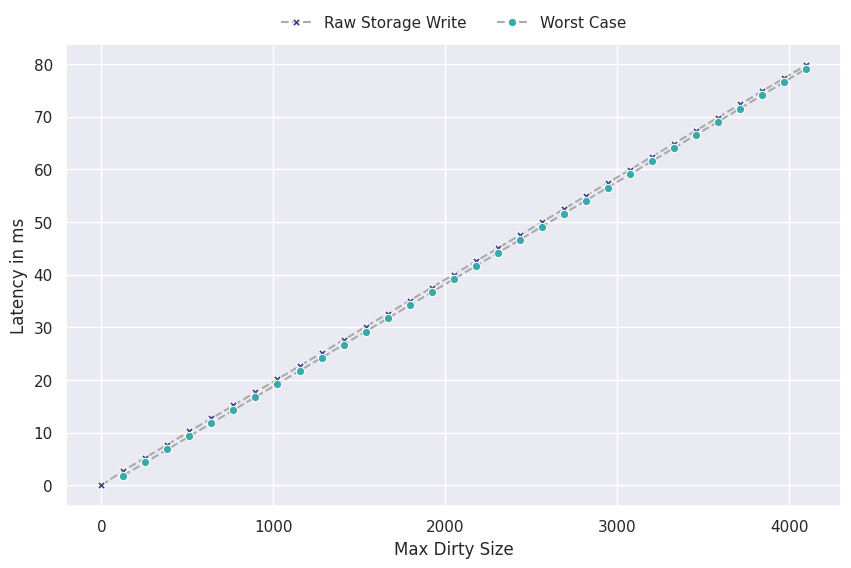

In [5]:
from typing import NamedTuple
from util import convert
from util.plot import plot_lines, PlotLinesOptions, LinePlotEntry

scale = 128

plot_data = [{
    "name": "Raw Storage Write",
    "x": "options.object_size",
    "y": "mean",
    "marker": "X",
    "data": dataset[(dataset["benchmark_id"] == "persistent_storage_write") & (dataset["options.object_size"] <= 4 * 1024) & (dataset["options.object_size"] % scale == 0)],
},{
    "name": "Worst Case",
    "x": "options.dirty_size",
    "y": "mean",
    "marker": "o",
    "data": dataset[(dataset["benchmark_id"] == "max_dirty_persist_latency_dirty_size") & (dataset["options.dirty_size"] % scale == 0)],
}]

options = {
    "data": plot_data,
    "scale": unit,
    "x_label": "Max Dirty Size",
    "y_label": f"Latency in {unit}",
}

plot_lines(options)

[{'name': 'Raw Storage Write', 'x': 'options.object_size', 'y': 'mean', 'marker': 'o', 'data':           mean      min      max  options.object_size machine_name  \
16     84226.2    83705    88910                256.0      esp32c3   
24    123976.4   123456   128660                384.0      esp32c3   
32    163727.0   163206   168411                512.0      esp32c3   
40    203477.3   202956   208161                640.0      esp32c3   
48    243227.6   242707   247911                768.0      esp32c3   
56    282978.0   282457   287662                896.0      esp32c3   
64    322728.5   322208   327413               1024.0      esp32c3   
72    362478.8   361958   367163               1152.0      esp32c3   
80    402229.2   401708   406914               1280.0      esp32c3   
88    441979.6   441459   446664               1408.0      esp32c3   
96    481730.2   481209   486414               1536.0      esp32c3   
104   521480.4   520960   526164               1664.0      esp32c

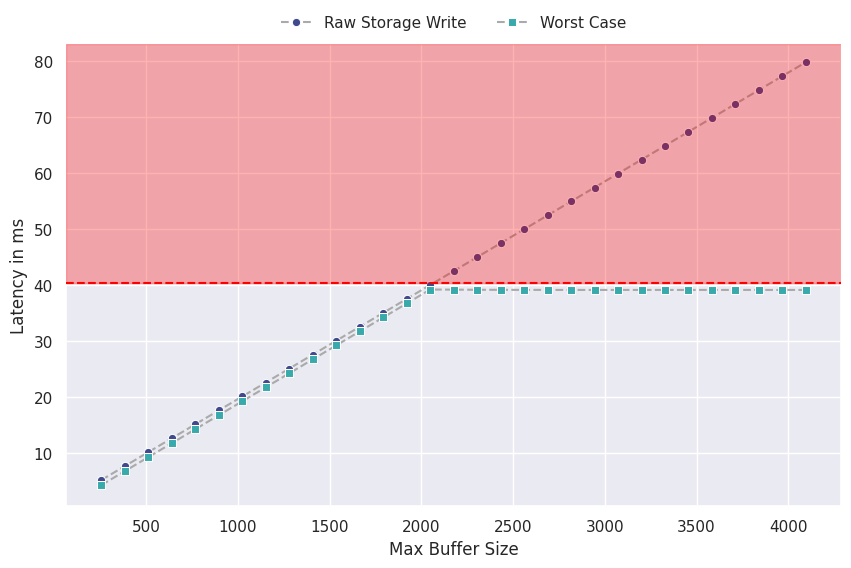

In [6]:
from typing import NamedTuple
from util import convert
from util.plot import plot_lines, PlotLinesOptions, LinePlotEntry
import seaborn as sbn

scale = 128
limit = 4 * 1024

plot_data = [{
    "name": "Raw Storage Write",
    "x": "options.object_size",
    "y": "mean",
    "marker": "o",
    "data": dataset[(dataset["benchmark_id"] == "persistent_storage_write") & (dataset["options.object_size"] <= limit) & (dataset["options.object_size"] >= 256) & (dataset["options.object_size"] % scale == 0)],
},{
    "name": "Worst Case",
    "x": "options.buffer_size",
    "y": "mean",
    "marker": "s",
    "data": dataset[(dataset["benchmark_id"] == "max_dirty_persist_latency_buffer_size") & (dataset["options.buffer_size"] % scale == 0)],
}]
print(plot_data)

options = {
    "data": plot_data,
    "scale": unit,
    "x_label": "Max Buffer Size",
    "y_label": f"Latency in {unit}",
}

ax = plot_lines(options)

offset_multiplier = 0.03
scaled = convert.scale_data(dataset[(dataset["benchmark_id"] == "max_dirty_persist_latency_buffer_size") & (dataset["options.buffer_size"] % scale == 0)], unit)
line = scaled["mean"].max() + scaled["mean"].max() * offset_multiplier

limit = (convert.scale_data(dataset[(dataset["benchmark_id"] == "persistent_storage_write") & (dataset["options.object_size"] <= limit)], unit))["mean"].max()
limit = limit + 0.04 * limit

ax.axhline(line, ls='--', color="red", zorder=11)
ax.set_ylim(top=limit)
ax.axhspan(line, limit, alpha=0.3, color="red",zorder=10)